In [1]:
import warnings
warnings.filterwarnings('ignore')

from src.data import DataLoaders
from src import utils
import pandas as pd
from src.models.ModelClasses import FireRiskModels, SmokeAlarmModels
from matplotlib import pyplot as plt
from pathlib import Path
from datetime import date, datetime
import numpy as np
#import geopandas as geo
import subprocess

from IPython.display import display, Markdown

Create report with: `jupyter nbconvert --to pdf --output withMarkdownPDF --TagRemovePreprocessor.enabled=True --TagRemovePreprocessor.remove_cell_tags=['remove_cell']  --no-input testScript.ipynb`

# Fire Models

In [2]:
expt_num = 2 

In [3]:
# grab version of code 
#subprocess.check_output(['git', 'rev-parse', '--short', 'HEAD'])

In [4]:

  
expt_path =  Path.cwd() / 'Data' /  'Logs' / f'Experiment_{expt_num}'

In [2]:
display(Markdown('**The following columns are being kept**'))
ACS_cols_to_use =[ 'did_not_work_past_12_mo',
               'house_pct_live_alone',
               'pct_alt_heat',
               'house_yr_pct_before_1960',
               'inc_pct_poverty',
               'race_pct_black_or_amind']
print(ACS_cols_to_use)

**The following columns are being kept**

['did_not_work_past_12_mo', 'house_pct_live_alone', 'pct_alt_heat', 'house_yr_pct_before_1960', 'inc_pct_poverty', 'race_pct_black_or_amind']


In [6]:
expt_log =  pd.DataFrame( {'Experiment Number': expt_num ,
 'Date': datetime.now(),
 'Log_folder' : expt_path,
 'Code_Repo' :   'NA', #subprocess.check_output(['git', 'config', '--get', 'remote.origin.url']),                        
 'Code_Version': 'NA', #subprocess.check_output(['git', 'rev-parse', '--short', 'HEAD']).strip(),
 'ACS_Version': '2016',
 'Level': 'block_group',
 'NFIRS_Years_used_start': '2012',                                        
 'NFIRS_Years_used_end': '2017',
 'NFIRS_Year_predicted': '2018',
  'Severity_dollar_estimate' : 10000,
  'ACS_cols_used': [ACS_cols_to_use] 
} )
                                         

In [7]:
from datetime import datetime

In [8]:
print(datetime.now())

2022-08-15 21:07:52.118509


In [9]:
master_log_file_path = expt_path.parent / 'MasterLog.csv'

In [10]:
if master_log_file_path.exists():
    expt_log.to_csv ( master_log_file_path,mode ='a', header = False, index = False )
else:
    expt_log.to_csv ( master_log_file_path, header = True, index = False )

In [3]:
#DataLoaders.ACSData(2016,'block_group')- second parameter is level
ACS =  DataLoaders.ACSData(2016,'block_group', pop_thresh = 50)
ACS.data

,state,tot_population,in_poverty,inc_pct_poverty,inc_pcincome,race_pct_white,race_pct_whitenh,race_pct_nonwhite,race_pct_nonwhitenh,race_pct_black,...,house_yr_pct_before_1960,house_yr_pct_after_2000,house_yr_pct_1960_2000,house_val_less_50K,house_val_50_100K,house_val_100K_300K,house_val_300K_500K,house_val_more_500K,race_pct_black_or_amind,pct_alt_heat
GEOID,,,,,,,,,,,,,,,,,,,,,
010010201001,AL,745.0,143.0,0.191946,20365.0,0.785235,0.763758,0.214765,0.236242,0.214765,...,0.221831,0.193662,0.584507,0.152047,0.274854,0.508772,0.064327,0.000000,0.214765,0.017606
010010201002,AL,1265.0,56.0,0.044269,33336.0,0.856126,0.826877,0.143874,0.173123,0.082213,...,0.079229,0.085653,0.835118,0.100264,0.153034,0.538259,0.174142,0.034301,0.082213,0.032895
010010202001,AL,955.0,365.0,0.382199,17047.0,0.376042,0.376042,0.623958,0.623958,0.591667,...,0.135678,0.211055,0.653266,0.171053,0.337719,0.394737,0.065789,0.030702,0.591667,0.000000
010010202002,AL,1059.0,118.0,0.111426,21400.0,0.497573,0.488673,0.502427,0.511327,0.461974,...,0.235772,0.075203,0.689024,0.053691,0.513423,0.412752,0.020134,0.000000,0.461974,0.019912
010010203001,AL,2364.0,100.0,0.042301,23106.0,0.626481,0.626481,0.373519,0.373519,0.217851,...,0.030303,0.091887,0.877810,0.057522,0.349558,0.592920,0.000000,0.000000,0.227157,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
560459511001,WY,1457.0,137.0,0.094029,33781.0,0.950583,0.929307,0.049417,0.070693,0.000000,...,0.308305,0.121729,0.569966,0.089320,0.114563,0.666019,0.091262,0.038835,0.000000,0.366569
560459511002,WY,1582.0,99.0,0.062579,34002.0,0.935884,0.918642,0.064116,0.081358,0.009698,...,0.197500,0.337500,0.465000,0.123438,0.079687,0.525000,0.232812,0.039062,0.014547,0.825737
560459513001,WY,1151.0,301.0,0.261512,23326.0,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.556757,0.000000,0.443243,0.229282,0.303867,0.466851,0.000000,0.000000,0.000000,0.105163


In [4]:
ACS_county = DataLoaders.ACSData(2016, 'county', pop_thresh = 50)
ACS_county.data

,state,tot_population,in_poverty,inc_pct_poverty,inc_pcincome,race_pct_white,race_pct_whitenh,race_pct_nonwhite,race_pct_nonwhitenh,race_pct_black,...,house_yr_pct_before_1960,house_yr_pct_after_2000,house_yr_pct_1960_2000,house_val_less_50K,house_val_50_100K,house_val_100K_300K,house_val_300K_500K,house_val_more_500K,race_pct_black_or_amind,pct_alt_heat
GEOID,,,,,,,,,,,,,,,,,,,,,
01001,AL,54598.0,6697.0,0.122660,26178.948423,0.769551,0.757760,0.230449,0.242240,0.184333,...,0.075636,0.294664,0.629700,0.144171,0.192272,0.564726,0.085557,0.013274,0.188468,0.117837
01003,AL,196640.0,25551.0,0.129938,28156.409662,0.864939,0.832096,0.135061,0.167904,0.092353,...,0.075916,0.339992,0.584092,0.084371,0.118950,0.596030,0.137575,0.063074,0.099022,0.032655
01005,AL,23641.0,6235.0,0.263737,18156.073939,0.467411,0.459066,0.532589,0.540934,0.474980,...,0.192086,0.106423,0.701491,0.245668,0.287528,0.396123,0.044605,0.026077,0.476302,0.134071
01007,AL,20603.0,3390.0,0.164539,19864.397466,0.800467,0.780001,0.199533,0.219999,0.181294,...,0.182902,0.163843,0.653255,0.247900,0.261379,0.436218,0.051768,0.002735,0.184966,0.172957
01009,AL,57099.0,9441.0,0.165344,21044.373614,0.955075,0.878016,0.044925,0.121984,0.015184,...,0.159539,0.215849,0.624612,0.162052,0.214839,0.540544,0.062508,0.020057,0.018690,0.145933
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56037,WY,44166.0,4868.0,0.110221,30960.831884,0.922428,0.799483,0.077572,0.200517,0.008978,...,0.208355,0.194901,0.596744,0.185093,0.065700,0.587961,0.138653,0.022595,0.017486,0.036412
56039,WY,22524.0,1650.0,0.073255,46535.314731,0.926700,0.811996,0.073300,0.188004,0.007442,...,0.090506,0.211481,0.698014,0.041309,0.015394,0.183359,0.081645,0.678293,0.011651,0.164296
56041,WY,20658.0,3462.0,0.167586,25676.949269,0.943053,0.877808,0.056947,0.122192,0.001865,...,0.157961,0.136405,0.705634,0.152286,0.063708,0.619667,0.138129,0.026210,0.011556,0.161868


In [6]:
#include level 
NFIRS_county = DataLoaders.NFIRSData('county',ACS_county.tot_pop, pop_thresh = 50)
NFIRS_Sev_county = DataLoaders.NFIRSData('county',ACS_county.tot_pop,pop_thresh = 50, sev=True)

In [5]:
#include level 
NFIRS = DataLoaders.NFIRSData('block_group',ACS.tot_pop, pop_thresh = 50)
NFIRS_Sev = DataLoaders.NFIRSData('block_group',ACS.tot_pop,pop_thresh = 50, sev=True)

In [7]:
FSM =  FireRiskModels('severity')
FPM =  FireRiskModels('propensity')

In [8]:
display(Markdown('## Fire Propensity Model'))

FPM.train(NFIRS_county,ACS_county,ACS_cols_to_use)
#FPM.train(NFIRS,ACS,ACS_cols_to_use)

## Fire Propensity Model

Predicting 2017:


**Confusion Matrix**

[[2190  669]
 [  73  210]]


**ROC AUC Score** = 0.8460147547203857

**Classication Report**

              precision    recall  f1-score   support

       False       0.97      0.77      0.86      2859
        True       0.24      0.74      0.36       283

    accuracy                           0.76      3142
   macro avg       0.60      0.75      0.61      3142
weighted avg       0.90      0.76      0.81      3142



**Feature Ranking**

1. Max (0.343237)
2. Median (0.117647)
3. pct_alt_heat (0.110819)
4. race_pct_black_or_amind (0.108699)
5. inc_pct_poverty (0.085652)
6. did_not_work_past_12_mo (0.084807)
7. house_pct_live_alone (0.075486)
8. house_yr_pct_before_1960 (0.073654)


In [9]:
display(Markdown('## Fire Severity Model'))

FSM.train(NFIRS_Sev_county,ACS_county,ACS_cols_to_use)
#FSM.train(NFIRS_Sev,ACS,ACS_cols_to_use)

## Fire Severity Model

Predicting 2017:


**Confusion Matrix**

[[2236  660]
 [  64  182]]


**ROC AUC Score** = 0.8541512262498315

**Classication Report**

              precision    recall  f1-score   support

       False       0.97      0.77      0.86      2896
        True       0.22      0.74      0.33       246

    accuracy                           0.77      3142
   macro avg       0.59      0.76      0.60      3142
weighted avg       0.91      0.77      0.82      3142



**Feature Ranking**

1. Max (0.406339)
2. race_pct_black_or_amind (0.115707)
3. inc_pct_poverty (0.084286)
4. Median (0.082109)
5. did_not_work_past_12_mo (0.082056)
6. house_yr_pct_before_1960 (0.081612)
7. house_pct_live_alone (0.077125)
8. pct_alt_heat (0.070767)


In [10]:
ARC =  DataLoaders.ARCPData(ACS, 'ARC Preparedness Data.csv')

# Smoke Alarm Models

In [9]:
SVI =  DataLoaders.SVIData(ACS.data, ACS.tot_pop, 'block_group')
SVI.data

,inc_pct_poverty,RPL_THEME1,RPL_THEME2,RPL_THEME3,RPL_THEME4
geos,,,,,
010010201001,0.191946,0.3913,0.5597,0.3735,0.0993
010010201002,0.044269,0.3913,0.5597,0.3735,0.0993
010010202001,0.382199,0.7065,0.3585,0.5821,0.7299
010010202002,0.111426,0.7065,0.3585,0.5821,0.7299
010010203001,0.042301,0.5659,0.8729,0.6429,0.3882
...,...,...,...,...,...
560459511001,0.094029,0.3925,0.6370,0.2331,0.8555
560459511002,0.062579,0.3925,0.6370,0.2331,0.8555
560459513001,0.261512,0.5093,0.6043,0.2862,0.6949


In [11]:
SVI_county =  DataLoaders.SVIData(ACS_county.data, ACS.tot_pop, 'county')
SVI_county.data

             tot_population  RPL_THEME1  RPL_THEME2  RPL_THEME3  RPL_THEME4
GEOID                                                                      
01001020100          2010.0      0.3913      0.5597      0.3735      0.0993
01001020200          2014.0      0.7065      0.3585      0.5821      0.7299
01001020300          3136.0      0.5659      0.8729      0.6429      0.3882
01001020400          4563.0      0.1825      0.7960      0.3661      0.0585
01001020500         10320.0      0.2801      0.6475      0.4176      0.6590
...                     ...         ...         ...         ...         ...
56043000200          3050.0      0.4619      0.6913      0.1022      0.8124
56043000301          2495.0      0.5088      0.7811      0.3546      0.5951
56043000302          2629.0      0.6885      0.8272      0.3455      0.5388
56045951100          3039.0      0.3925      0.6370      0.2331      0.8555
56045951300          3780.0      0.5093      0.6043      0.2862      0.6949

[72142 rows

,RPL_THEME1,RPL_THEME2,RPL_THEME3,RPL_THEME4,inc_pct_poverty
GEOID,,,,,
01001,0.458660,0.679522,0.359982,0.490418,0.122660
01003,0.405037,0.524210,0.258139,0.504242,0.129938
01005,0.880776,0.833647,0.630959,0.591735,0.263737
01007,0.673781,0.516063,0.221158,0.627417,0.164539
01009,0.624344,0.627232,0.354505,0.501772,0.165344
...,...,...,...,...,...
56037,0.424865,0.521423,0.403175,0.545971,0.110221
56039,0.109058,0.116232,0.540475,0.730831,0.073255
56041,0.499908,0.694255,0.263928,0.741195,0.167586


In [12]:
Smoke = SmokeAlarmModels()

Training State smoke alarm stats model
Training County smoke alarm stats model
Training Tract smoke alarm stats model
Training Block_Group smoke alarm stats model
Training MultiLevel smoke alarm stats model
sm
(1644, 7)
(3142, 7)


**Training Performance**

1.918248522576297
Test RMSE: 1.385008491878767
Test MAE: 0.9815316831349422


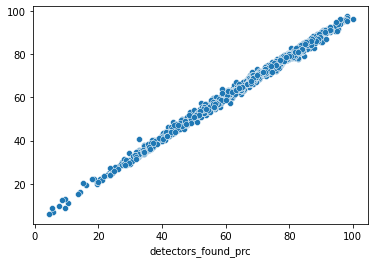

**Testing Performance**

Test RMSE: 17.43807942261543
Test MAE: 13.710711395124534


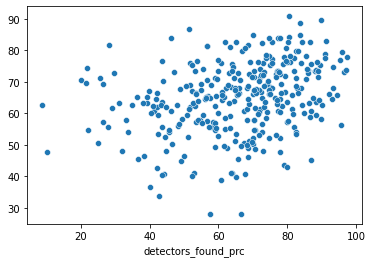

Test Correlation: (0.30480256561260155, 1.6769545013572884e-08)
Test R-squared: -0.03231314164633203


**Feature Ranking**

1. RPL_THEME1 (0.236634)
2. inc_pct_poverty_x (0.094384)
3. RPL_THEME2 (0.092675)
4. pct_alt_heat (0.086282)
5. house_yr_pct_before_1960 (0.083945)
6. race_pct_black_or_amind (0.083273)
7. RPL_THEME3 (0.081264)
8. RPL_THEME4 (0.066313)
9. house_pct_live_alone (0.063659)
10. did_not_work_past_12_mo (0.063023)
11. Population Density (per square mile), 2010 (0.048548)
12. inc_pct_poverty_y (0.000000)


In [13]:
svi_use = True
smoke_prediction = Smoke.trainModels(ARC,ACS_county.data,ACS.tot_pop, SVI_county, ACS_cols_to_use,svi_use, utils.DATA['data'], 'county')
#smoke_prediction = Smoke.trainModels(ARC,ACS.data,ACS.tot_pop, SVI, ACS_cols_to_use,svi_use, utils.DATA['data'], 'block_group')

# Saving File

In [14]:
level = 'county'
ACS = ACS_county
SVI = SVI_county
NFIRS = NFIRS_county
NFIRS_Sev = NFIRS_Sev_county

In [14]:
level = 'block_group'

In [15]:
out = NFIRS.fires.copy()
out.columns =  'fires_per_1K_pop_' + out.columns
cols = out.columns

In [16]:
out = ACS.data.merge(out, how = 'left', left_index = True, right_index = True)
out = out[cols]

In [18]:
# Smoke Alarm model munging 


# add number of surveys recorded at the block level
if level == 'block_group':
    num_surveys = Smoke.models['Block_Group']['num_surveys'].copy()
elif level == 'tract':
    num_surveys = Smoke.models['Tract']['num_surveys'].copy()
else:
    num_surveys = Smoke.models['County']['num_surveys'].copy()
num_surveys.index = num_surveys.index.str[2:]


out['recorded_home_visits'] = num_surveys


# add the statistical model outputs 
if level == 'block_group':
    Smoke_predicts = Smoke.models['MultiLevel'][
    [ 'detectors_working_prc','detectors_working_CI','geography']].copy()
elif level == 'tract':
    Smoke_predicts = Smoke.models['Tract'][
    [ 'detectors_working_prc','detectors_working_CI']].copy()
    Smoke_predicts['geography'] =  'NA'
else:
    Smoke_predicts = Smoke.models['County'][
    [ 'detectors_working_prc','detectors_working_CI']].copy() 
    Smoke_predicts['geography'] =  'NA'
    
Smoke_predicts.index = Smoke_predicts.index.str[2:]
out = out.merge(Smoke_predicts,how = 'left', left_index = True, right_index = True)

## add DL model to outputs
DL = pd.DataFrame(smoke_prediction['Population Density (per square mile), 2010'])
#DL['detectors_predicted'] = smoke_prediction['Predictions'].copy()

out = out.merge(DL,how = 'left', left_index = True, right_index = True)

In [19]:
out

,fires_per_1K_pop_2009,fires_per_1K_pop_2010,fires_per_1K_pop_2011,fires_per_1K_pop_2012,fires_per_1K_pop_2013,fires_per_1K_pop_2014,fires_per_1K_pop_2015,fires_per_1K_pop_2016,fires_per_1K_pop_2017,recorded_home_visits,detectors_working_prc,detectors_working_CI,geography,"Population Density (per square mile), 2010"
GEOID,,,,,,,,,,,,,,
01001,0.750943,0.549471,0.567786,0.293051,0.457892,0.201473,0.531155,0.457892,0.567786,12,8.33,15.635132,NA,91.777666
01003,0.386493,0.533971,0.447518,0.523800,0.462775,0.671277,0.503458,0.508544,0.737388,95,52.63,10.040669,NA,114.646496
01005,0.719090,0.888287,0.169198,0.507593,0.211497,0.296096,0.126898,0.169198,0.761389,15,20.00,20.242793,NA,31.028365
01007,0.097073,0.145610,0.194146,0.242683,NaN,NaN,0.097073,0.194146,0.388293,14,42.86,25.923179,NA,36.805332
01009,0.420323,0.437836,0.647997,0.315242,0.245188,0.262702,0.367782,0.928212,0.875672,47,10.64,8.815553,NA,88.898883
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56037,0.633972,0.611330,0.316986,0.520763,NaN,0.475479,0.339628,0.543404,0.407553,31,51.61,17.592192,NA,4.201329
56039,0.310780,NaN,0.133191,0.488368,NaN,NaN,0.887942,0.088794,0.621559,7,71.43,33.465899,NA,5.329629
56041,0.726111,0.871333,0.677704,0.338852,NaN,0.290444,0.290444,0.096815,0.338852,0,0.00,0.000000,NA,10.146543


In [20]:
## add DL model to outputs
DL = pd.DataFrame(smoke_prediction['Population Density (per square mile), 2010'])
DL['detectors_predicted'] = smoke_prediction['Predictions'].copy()

out = out.merge(DL,how = 'left', left_index = True, right_index = True)

In [21]:
out['smoke_detector_risk_frac'] =  1 - out['detectors_predicted'] / 100
out['smoke_detector_risk_score'] =  out['smoke_detector_risk_frac'].rank(pct=True)
out[['smoke_detector_risk_frac','smoke_detector_risk_score']]

,smoke_detector_risk_frac,smoke_detector_risk_score
GEOID,,
01001,0.300455,0.340547
01003,0.225427,0.159134
01005,0.656577,0.962444
01007,0.492253,0.799491
01009,0.667695,0.969446
...,...,...
56037,0.234741,0.180140
56039,0.367555,0.523552
56041,0.167282,0.060153


In [23]:
# add final invidual predictors 

out['SVI_Theme_1'] = SVI.data['RPL_THEME1'].replace(-999.0, np.NaN)

out['fire_propensity_risk_score'] = FPM.test_prediction_probs[:,1]
out['fire_severity_risk_score'] = FSM.test_prediction_probs[:,1]



In [24]:
# create and add final predictor 

#create fire_risk_score by weighing propensity and severity at a .8 to .2 ratio.
#We want the fire_risk_score to be half of the overall combinedRiskScore so multiple the fire_risk_score by 2.
out['fire_prop_weighted'] = out['fire_propensity_risk_score']*0.8
out['fire_sev_weighted'] = out['fire_severity_risk_score']*0.2
out['fire_risk_score'] = out['fire_prop_weighted']+out['fire_sev_weighted']

out['CombinedRiskScore'] =  out.loc[:,['smoke_detector_risk_score',
                                       'fire_risk_score'] ].mean(axis = 1, skipna = True) #False )

In [25]:
display(Markdown('**Combined Risk Score Summary:**'))

out['CombinedRiskScore'].describe()

**Combined Risk Score Summary:**

count    3142.000000
mean        0.402014
std         0.232507
min         0.002664
25%         0.218870
50%         0.395830
75%         0.540223
max         0.992059
Name: CombinedRiskScore, dtype: float64

In [26]:
out_name = f"CombinedModels-basic{level}-{date.today()}.csv"
out_save = out.copy()
out_save.index = '#_' + out_save.index
out_save.to_csv(utils.DATA['model-outputs'] / out_name)

In [27]:
# alternate risk score ideas 

#out['CombinedRiskScore'] = (out[["fire_severity_risk_score", "fire_propensity_risk_score"]].max(axis=1) + out['smoke_detector_risk_score'])*100

In [27]:
out_columns = ['state','NFIRS_start','NFIRS_end','years_fires_reported','total_fires_reported', 'max_fires_1k', 
               'median_fires_1k','total_fires_reported_sev', 'max_fires_1k_sev', 'median_fires_1k_sev',
               'fire_propensity_risk_score','fire_severity_risk_score', 'fire_risk_score', 'recorded_home_visits',
              'smoke_detector_risk_frac', 'smoke_detector_risk_score','geography', 'SVI_Theme_1','CombinedRiskScore',
              'did_not_work_past_12_mo', 'house_pct_live_alone', 'pct_alt_heat', 'house_yr_pct_before_1960', 
               'inc_pct_poverty', 'race_pct_black_or_amind', 'tot_population', 'house_tot_occ_cnt', 'inc_pcincome', 
               'inc_hhmean', 'race_pct_white', 'race_pct_whitenh','race_pct_whiteh', 'race_pct_nwhitenh', 
               'race_pct_hisp',  'race_pct_black', 'race_pct_amind',  'race_pct_asian', 'race_pct_napi', 'race_pct_other', 
               'race_pct_two+','age_pct_under25', 'age_pct_over65',  'disability_pct', 'snap_past_12_mo', 'single_unit_home', 
               'multi_unit_home', 'mobile_home', 'boat_van_rv_home', 'spanish_speaking', 'state_id', 'state_rank', 'county_id', 'county_rank']
display(Markdown('**Saving columns:**'))
out_columns

**Saving columns:**

['state',
 'NFIRS_start',
 'NFIRS_end',
 'years_fires_reported',
 'total_fires_reported',
 'max_fires_1k',
 'median_fires_1k',
 'total_fires_reported_sev',
 'max_fires_1k_sev',
 'median_fires_1k_sev',
 'fire_propensity_risk_score',
 'fire_severity_risk_score',
 'fire_risk_score',
 'recorded_home_visits',
 'smoke_detector_risk_frac',
 'smoke_detector_risk_score',
 'geography',
 'SVI_Theme_1',
 'CombinedRiskScore',
 'did_not_work_past_12_mo',
 'house_pct_live_alone',
 'pct_alt_heat',
 'house_yr_pct_before_1960',
 'inc_pct_poverty',
 'race_pct_black_or_amind',
 'tot_population',
 'house_tot_occ_cnt',
 'inc_pcincome',
 'inc_hhmean',
 'race_pct_white',
 'race_pct_whitenh',
 'race_pct_whiteh',
 'race_pct_nwhitenh',
 'race_pct_hisp',
 'race_pct_black',
 'race_pct_amind',
 'race_pct_asian',
 'race_pct_napi',
 'race_pct_other',
 'race_pct_two+',
 'age_pct_under25',
 'age_pct_over65',
 'disability_pct',
 'snap_past_12_mo',
 'single_unit_home',
 'multi_unit_home',
 'mobile_home',
 'boat_van_rv_ho

In [28]:
years = FSM.years_used
years

array(['2011', '2012', '2013', '2014', '2015', '2016', '2017'],
      dtype=object)

In [29]:
out['NFIRS_start'] = min(years)
out['NFIRS_start'] = out['NFIRS_start'].astype(int)
out['NFIRS_end'] = max(years)
out['NFIRS_end'] = out['NFIRS_end'].astype(int)
out

,fires_per_1K_pop_2009,fires_per_1K_pop_2010,fires_per_1K_pop_2011,fires_per_1K_pop_2012,fires_per_1K_pop_2013,fires_per_1K_pop_2014,fires_per_1K_pop_2015,fires_per_1K_pop_2016,fires_per_1K_pop_2017,recorded_home_visits,...,smoke_detector_risk_score,SVI_Theme_1,fire_propensity_risk_score,fire_severity_risk_score,fire_prop_weighted,fire_sev_weighted,fire_risk_score,CombinedRiskScore,NFIRS_start,NFIRS_end
GEOID,,,,,,,,,,,,,,,,,,,,,
01001,0.750943,0.549471,0.567786,0.293051,0.457892,0.201473,0.531155,0.457892,0.567786,12,...,0.340547,0.458660,0.003780,0.004219,0.003024,0.000844,0.003867,0.172207,2011,2017
01003,0.386493,0.533971,0.447518,0.523800,0.462775,0.671277,0.503458,0.508544,0.737388,95,...,0.159134,0.405037,0.002344,0.006465,0.001875,0.001293,0.003168,0.081151,2011,2017
01005,0.719090,0.888287,0.169198,0.507593,0.211497,0.296096,0.126898,0.169198,0.761389,15,...,0.962444,0.880776,0.085835,0.867506,0.068668,0.173501,0.242169,0.602307,2011,2017
01007,0.097073,0.145610,0.194146,0.242683,NaN,NaN,0.097073,0.194146,0.388293,14,...,0.799491,0.673781,0.021313,0.002159,0.017050,0.000432,0.017482,0.408486,2011,2017
01009,0.420323,0.437836,0.647997,0.315242,0.245188,0.262702,0.367782,0.928212,0.875672,47,...,0.969446,0.624344,0.345075,0.020231,0.276060,0.004046,0.280107,0.624776,2011,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56037,0.633972,0.611330,0.316986,0.520763,NaN,0.475479,0.339628,0.543404,0.407553,31,...,0.180140,0.424865,0.000773,0.008163,0.000619,0.001633,0.002251,0.091196,2011,2017
56039,0.310780,NaN,0.133191,0.488368,NaN,NaN,0.887942,0.088794,0.621559,7,...,0.523552,0.109058,0.015900,0.010563,0.012720,0.002113,0.014833,0.269192,2011,2017
56041,0.726111,0.871333,0.677704,0.338852,NaN,0.290444,0.290444,0.096815,0.338852,0,...,0.060153,0.499908,0.000971,0.007969,0.000777,0.001594,0.002371,0.031262,2011,2017


In [30]:
fires_trained = NFIRS.fires_noAdjustment[years]
fires_trained2 = fires_trained>0
fires_trained2['years_fires_reported']= fires_trained2.sum(axis = 1)
fires_trained2 = fires_trained2['years_fires_reported']
out = out.merge(fires_trained2, how = 'left', left_index = True, right_index = True)

fires_trained = NFIRS.fires_noAdjustment[years]
fires_trained['total_fires_reported'] = fires_trained.sum(axis = 1)
fires_trained = fires_trained['total_fires_reported']
out = out.merge(fires_trained, how = 'left', left_index = True, right_index = True)

fires_trained = NFIRS.fires[years]
fires_trained2 = np.nanmax(fires_trained, axis =1)
fires_trained['max_fires_1k'] = fires_trained2
fires_trained2 = fires_trained['max_fires_1k']
out = out.merge(fires_trained2, how = 'left', left_index = True, right_index = True)

fires_trained = NFIRS.fires[years]
fires_trained2 = np.nanmedian(fires_trained, axis =1)
fires_trained['median_fires_1k'] = fires_trained2
fires_trained2 = fires_trained['median_fires_1k']
out = out.merge(fires_trained2, how = 'left', left_index = True, right_index = True)
out

,fires_per_1K_pop_2009,fires_per_1K_pop_2010,fires_per_1K_pop_2011,fires_per_1K_pop_2012,fires_per_1K_pop_2013,fires_per_1K_pop_2014,fires_per_1K_pop_2015,fires_per_1K_pop_2016,fires_per_1K_pop_2017,recorded_home_visits,...,fire_prop_weighted,fire_sev_weighted,fire_risk_score,CombinedRiskScore,NFIRS_start,NFIRS_end,years_fires_reported,total_fires_reported,max_fires_1k,median_fires_1k
GEOID,,,,,,,,,,,,,,,,,,,,,
01001,0.750943,0.549471,0.567786,0.293051,0.457892,0.201473,0.531155,0.457892,0.567786,12,...,0.003024,0.000844,0.003867,0.172207,2011,2017,7,168.0,0.567786,0.457892
01003,0.386493,0.533971,0.447518,0.523800,0.462775,0.671277,0.503458,0.508544,0.737388,95,...,0.001875,0.001293,0.003168,0.081151,2011,2017,7,758.0,0.737388,0.508544
01005,0.719090,0.888287,0.169198,0.507593,0.211497,0.296096,0.126898,0.169198,0.761389,15,...,0.068668,0.173501,0.242169,0.602307,2011,2017,7,53.0,0.761389,0.211497
01007,0.097073,0.145610,0.194146,0.242683,NaN,NaN,0.097073,0.194146,0.388293,14,...,0.017050,0.000432,0.017482,0.408486,2011,2017,5,23.0,0.388293,0.194146
01009,0.420323,0.437836,0.647997,0.315242,0.245188,0.262702,0.367782,0.928212,0.875672,47,...,0.276060,0.004046,0.280107,0.624776,2011,2017,7,208.0,0.928212,0.367782
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56037,0.633972,0.611330,0.316986,0.520763,NaN,0.475479,0.339628,0.543404,0.407553,31,...,0.000619,0.001633,0.002251,0.091196,2011,2017,6,115.0,0.543404,0.441516
56039,0.310780,NaN,0.133191,0.488368,NaN,NaN,0.887942,0.088794,0.621559,7,...,0.012720,0.002113,0.014833,0.269192,2011,2017,5,50.0,0.887942,0.488368
56041,0.726111,0.871333,0.677704,0.338852,NaN,0.290444,0.290444,0.096815,0.338852,0,...,0.000777,0.001594,0.002371,0.031262,2011,2017,6,42.0,0.677704,0.314648


In [31]:
fires_trained = NFIRS_Sev.fires_noAdjustment[years]
fires_trained['total_fires_reported_sev'] = fires_trained.sum(axis = 1)
fires_trained = fires_trained['total_fires_reported_sev']
out = out.merge(fires_trained, how = 'left', left_index = True, right_index = True)

fires_trained = NFIRS_Sev.fires[years]
fires_trained2 = np.nanmax(fires_trained, axis =1)
fires_trained['max_fires_1k_sev'] = fires_trained2
fires_trained2 = fires_trained['max_fires_1k_sev']
out = out.merge(fires_trained2, how = 'left', left_index = True, right_index = True)

fires_trained = NFIRS_Sev.fires[years]
fires_trained2 = np.nanmedian(fires_trained, axis =1)
fires_trained['median_fires_1k_sev'] = fires_trained2
fires_trained2 = fires_trained['median_fires_1k_sev']
out = out.merge(fires_trained2, how = 'left', left_index = True, right_index = True)
out

,fires_per_1K_pop_2009,fires_per_1K_pop_2010,fires_per_1K_pop_2011,fires_per_1K_pop_2012,fires_per_1K_pop_2013,fires_per_1K_pop_2014,fires_per_1K_pop_2015,fires_per_1K_pop_2016,fires_per_1K_pop_2017,recorded_home_visits,...,CombinedRiskScore,NFIRS_start,NFIRS_end,years_fires_reported,total_fires_reported,max_fires_1k,median_fires_1k,total_fires_reported_sev,max_fires_1k_sev,median_fires_1k_sev
GEOID,,,,,,,,,,,,,,,,,,,,,
01001,0.750943,0.549471,0.567786,0.293051,0.457892,0.201473,0.531155,0.457892,0.567786,12,...,0.172207,2011,2017,7,168.0,0.567786,0.457892,38.0,0.164841,0.109894
01003,0.386493,0.533971,0.447518,0.523800,0.462775,0.671277,0.503458,0.508544,0.737388,95,...,0.081151,2011,2017,7,758.0,0.737388,0.508544,133.0,0.122050,0.091538
01005,0.719090,0.888287,0.169198,0.507593,0.211497,0.296096,0.126898,0.169198,0.761389,15,...,0.602307,2011,2017,7,53.0,0.761389,0.211497,15.0,0.338395,0.169198
01007,0.097073,0.145610,0.194146,0.242683,NaN,NaN,0.097073,0.194146,0.388293,14,...,0.408486,2011,2017,5,23.0,0.388293,0.194146,5.0,0.097073,0.048537
01009,0.420323,0.437836,0.647997,0.315242,0.245188,0.262702,0.367782,0.928212,0.875672,47,...,0.624776,2011,2017,7,208.0,0.928212,0.367782,51.0,0.315242,0.087567
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56037,0.633972,0.611330,0.316986,0.520763,NaN,0.475479,0.339628,0.543404,0.407553,31,...,0.091196,2011,2017,6,115.0,0.543404,0.441516,32.0,0.226419,0.135851
56039,0.310780,NaN,0.133191,0.488368,NaN,NaN,0.887942,0.088794,0.621559,7,...,0.269192,2011,2017,5,50.0,0.887942,0.488368,11.0,0.177588,0.133191
56041,0.726111,0.871333,0.677704,0.338852,NaN,0.290444,0.290444,0.096815,0.338852,0,...,0.031262,2011,2017,6,42.0,0.677704,0.314648,3.0,0.048407,0.048407


In [32]:
ACS_toCombine = ACS.data
#check this makes sense
ACS_toCombine['inc_hhmean'] = ACS_toCombine['inc_pcincome']*ACS_toCombine['tot_population']/ACS_toCombine['house_tot_occ_cnt']
ACS_toCombine['inc_hhmean'] = ACS_toCombine['inc_hhmean'].round()
ACS_toCombine['race_pct_whiteh'] = ACS_toCombine['race_pct_white']-ACS_toCombine['race_pct_whitenh']
ACS_toCombine['race_pct_nwhitenh'] = 1-ACS_toCombine['race_pct_hisp']-ACS_toCombine['race_pct_whitenh']
ACS_toCombine['race_pct_nwhitenh'] = ACS_toCombine['race_pct_nwhitenh'].round(5)


ACS_keep = ACS_toCombine[['state',
    'did_not_work_past_12_mo', 'house_pct_live_alone', 'pct_alt_heat', 'house_yr_pct_before_1960', 
    'inc_pct_poverty', 'race_pct_black_or_amind', 'tot_population', 'house_tot_occ_cnt', 'inc_pcincome', 
    'inc_hhmean', 'race_pct_white', 'race_pct_whitenh','race_pct_whiteh', 'race_pct_nwhitenh', 
    'race_pct_hisp',  'race_pct_black', 'race_pct_amind',  'race_pct_asian', 'race_pct_napi', 'race_pct_other', 
    'race_pct_two+','age_pct_under25', 'age_pct_over65',  'disability_pct', 'snap_past_12_mo', 'single_unit_home', 
    'multi_unit_home', 'mobile_home', 'boat_van_rv_home', 'spanish_speaking'
    ]]
ACS_keep = ACS_keep.replace(-666666666.0, np.nan)
ACS_keep = ACS_keep.replace(np.inf, np.nan)

In [33]:
out = out.merge(ACS_keep, how = 'left', left_index = True, right_index = True)
out

,fires_per_1K_pop_2009,fires_per_1K_pop_2010,fires_per_1K_pop_2011,fires_per_1K_pop_2012,fires_per_1K_pop_2013,fires_per_1K_pop_2014,fires_per_1K_pop_2015,fires_per_1K_pop_2016,fires_per_1K_pop_2017,recorded_home_visits,...,race_pct_two+,age_pct_under25,age_pct_over65,disability_pct,snap_past_12_mo,single_unit_home,multi_unit_home,mobile_home,boat_van_rv_home,spanish_speaking
GEOID,,,,,,,,,,,,,,,,,,,,,
01001,0.750943,0.549471,0.567786,0.293051,0.457892,0.201473,0.531155,0.457892,0.567786,12,...,0.019504,0.337628,0.139963,0.347003,0.127977,0.728978,0.089284,0.180285,0.001453,0.022453
01003,0.386493,0.533971,0.447518,0.523800,0.462775,0.671277,0.503458,0.508544,0.737388,95,...,0.020327,0.298873,0.187231,0.263131,0.089366,0.630123,0.249631,0.119252,0.000995,0.044759
01005,0.719090,0.888287,0.169198,0.507593,0.211497,0.296096,0.126898,0.169198,0.761389,15,...,0.005240,0.328502,0.173040,0.401597,0.257016,0.576597,0.121674,0.299441,0.002288,0.050249
01007,0.097073,0.145610,0.194146,0.242683,NaN,NaN,0.097073,0.194146,0.388293,14,...,0.013765,0.320549,0.151724,0.318074,0.146243,0.643781,0.072113,0.284106,0.000000,0.014411
01009,0.420323,0.437836,0.647997,0.315242,0.245188,0.262702,0.367782,0.928212,0.875672,47,...,0.016088,0.315907,0.172013,0.300140,0.116018,0.731656,0.038784,0.229224,0.000335,0.057006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56037,0.633972,0.611330,0.316986,0.520763,NaN,0.475479,0.339628,0.543404,0.407553,31,...,0.034314,0.365076,0.094774,0.244424,0.044100,0.616271,0.158779,0.224322,0.000628,0.093154
56039,0.310780,NaN,0.133191,0.488368,NaN,NaN,0.887942,0.088794,0.621559,7,...,0.009976,0.252004,0.118485,0.116231,0.014235,0.702453,0.260909,0.030319,0.006320,0.124490
56041,0.726111,0.871333,0.677704,0.338852,NaN,0.290444,0.290444,0.096815,0.338852,0,...,0.030348,0.375898,0.106618,0.307708,0.083410,0.612454,0.133782,0.246122,0.007641,0.081690


In [34]:
out['state_id'] = '#_' + out.index
out['state_id'] = out['state_id'].str[:4]
out['state_rank'] = out.groupby('state_id')['CombinedRiskScore'].rank(ascending=False)
out['county_id'] = '#_' + out.index
out['county_id'] = out['county_id'].str[:7]
out['county_rank'] = out.groupby('county_id')['CombinedRiskScore'].rank(ascending=False)

In [35]:
out_final = out[out_columns]
if level is not 'block_group':
    print('removing geography column')
    out_final = out_final.drop(columns=['geography'])
out_final

,state,NFIRS_start,NFIRS_end,years_fires_reported,total_fires_reported,max_fires_1k,median_fires_1k,total_fires_reported_sev,max_fires_1k_sev,median_fires_1k_sev,...,snap_past_12_mo,single_unit_home,multi_unit_home,mobile_home,boat_van_rv_home,spanish_speaking,state_id,state_rank,county_id,county_rank
GEOID,,,,,,,,,,,,,,,,,,,,,
01001,AL,2011,2017,7,168.0,0.567786,0.457892,38.0,0.164841,0.109894,...,0.127977,0.728978,0.089284,0.180285,0.001453,0.022453,#_01,63.0,#_01001,1.0
01003,AL,2011,2017,7,758.0,0.737388,0.508544,133.0,0.122050,0.091538,...,0.089366,0.630123,0.249631,0.119252,0.000995,0.044759,#_01,66.0,#_01003,1.0
01005,AL,2011,2017,7,53.0,0.761389,0.211497,15.0,0.338395,0.169198,...,0.257016,0.576597,0.121674,0.299441,0.002288,0.050249,#_01,13.0,#_01005,1.0
01007,AL,2011,2017,5,23.0,0.388293,0.194146,5.0,0.097073,0.048537,...,0.146243,0.643781,0.072113,0.284106,0.000000,0.014411,#_01,37.0,#_01007,1.0
01009,AL,2011,2017,7,208.0,0.928212,0.367782,51.0,0.315242,0.087567,...,0.116018,0.731656,0.038784,0.229224,0.000335,0.057006,#_01,11.0,#_01009,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56037,WY,2011,2017,6,115.0,0.543404,0.441516,32.0,0.226419,0.135851,...,0.044100,0.616271,0.158779,0.224322,0.000628,0.093154,#_56,19.0,#_56037,1.0
56039,WY,2011,2017,5,50.0,0.887942,0.488368,11.0,0.177588,0.133191,...,0.014235,0.702453,0.260909,0.030319,0.006320,0.124490,#_56,8.0,#_56039,1.0
56041,WY,2011,2017,6,42.0,0.677704,0.314648,3.0,0.048407,0.048407,...,0.083410,0.612454,0.133782,0.246122,0.007641,0.081690,#_56,22.0,#_56041,1.0


In [36]:
if level is not 'block_group':
    print('removing geography column')
    out = out.drop(columns=['geography'])
a = out.describe()
a.to_csv(utils.DATA['model-outputs']/f"summary-pop50-{level}-{date.today()}.csv")

removing geography column


In [37]:
out_name = f"CombinedModels-FileStructureColumns-pop50-{level}-{date.today()}.csv"
out_final.index = '#_' + out_final.index
out_final.to_csv(utils.DATA['model-outputs'] / out_name)

In [38]:
out_final

,state,NFIRS_start,NFIRS_end,years_fires_reported,total_fires_reported,max_fires_1k,median_fires_1k,total_fires_reported_sev,max_fires_1k_sev,median_fires_1k_sev,...,snap_past_12_mo,single_unit_home,multi_unit_home,mobile_home,boat_van_rv_home,spanish_speaking,state_id,state_rank,county_id,county_rank
GEOID,,,,,,,,,,,,,,,,,,,,,
#_01001,AL,2011,2017,7,168.0,0.567786,0.457892,38.0,0.164841,0.109894,...,0.127977,0.728978,0.089284,0.180285,0.001453,0.022453,#_01,63.0,#_01001,1.0
#_01003,AL,2011,2017,7,758.0,0.737388,0.508544,133.0,0.122050,0.091538,...,0.089366,0.630123,0.249631,0.119252,0.000995,0.044759,#_01,66.0,#_01003,1.0
#_01005,AL,2011,2017,7,53.0,0.761389,0.211497,15.0,0.338395,0.169198,...,0.257016,0.576597,0.121674,0.299441,0.002288,0.050249,#_01,13.0,#_01005,1.0
#_01007,AL,2011,2017,5,23.0,0.388293,0.194146,5.0,0.097073,0.048537,...,0.146243,0.643781,0.072113,0.284106,0.000000,0.014411,#_01,37.0,#_01007,1.0
#_01009,AL,2011,2017,7,208.0,0.928212,0.367782,51.0,0.315242,0.087567,...,0.116018,0.731656,0.038784,0.229224,0.000335,0.057006,#_01,11.0,#_01009,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
#_56037,WY,2011,2017,6,115.0,0.543404,0.441516,32.0,0.226419,0.135851,...,0.044100,0.616271,0.158779,0.224322,0.000628,0.093154,#_56,19.0,#_56037,1.0
#_56039,WY,2011,2017,5,50.0,0.887942,0.488368,11.0,0.177588,0.133191,...,0.014235,0.702453,0.260909,0.030319,0.006320,0.124490,#_56,8.0,#_56039,1.0
#_56041,WY,2011,2017,6,42.0,0.677704,0.314648,3.0,0.048407,0.048407,...,0.083410,0.612454,0.133782,0.246122,0.007641,0.081690,#_56,22.0,#_56041,1.0
